# Import Libraries & Dataset

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [34]:
# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 

display(cc_apps.head())
cc_apps.info()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.00,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.46,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.50,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.54,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.62,u,g,w,v,1.71,t,f,0,s,0,+


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    int64  
 13  13      690 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 75.6+ KB


# Data Profiling

Before moving on to the cleaning process, I'm going to create a profiling report to get a quick overview of the dataset using [ydata-profiling](https://github.com/ydataai/ydata-profiling).

You can see the result [here](https://rawcdn.githack.com/azizp128/data-science-projects/refs/heads/main/predicting-credit-card-approvals/y_profiling_report.html).

In [35]:
profile = ProfileReport(cc_apps, title="Profiling Report")
# profile.to_file("y_profiling_report.html")

# Data Cleaning

From the ydata-profiling report, we know that there are some columns with `?` values. We're going to replace it with NaN (Not a Number) to handle missing data properly, and then remove them from the dataset.

In [36]:
# Remove '?' from all rows
cc_apps = cc_apps.map(lambda x: np.nan if x == '?' else x)
cc_apps = cc_apps.dropna().reset_index(drop=True)

After we removed all the missing values from the dataset, next we convert some columns with numerical values to the correct data type.

In [37]:
# Convert numerical values into its type
float_features = [1, 2, 7]
int_features = [10, 12]

for col in cc_apps.columns:
    if col in float_features:
        cc_apps[col] = cc_apps[col].astype('float')
    elif col in int_features:
        cc_apps[col] = cc_apps[col].astype('int')

cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    object 
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    object 
 4   4       659 non-null    object 
 5   5       659 non-null    object 
 6   6       659 non-null    object 
 7   7       659 non-null    float64
 8   8       659 non-null    object 
 9   9       659 non-null    object 
 10  10      659 non-null    int32  
 11  11      659 non-null    object 
 12  12      659 non-null    int32  
 13  13      659 non-null    object 
dtypes: float64(3), int32(2), object(9)
memory usage: 67.1+ KB


# EDA

Let's check the distribution of numerical columns to identify skewness and outliers. Besides that, it's important to do this to ensure that model assumptions are met, as many ML algorithms (e.g., linear models, Gaussian Naive Bayes) assume that input features follow a normal distribution. If the data is not normally distributed, the model's performance may suffer.

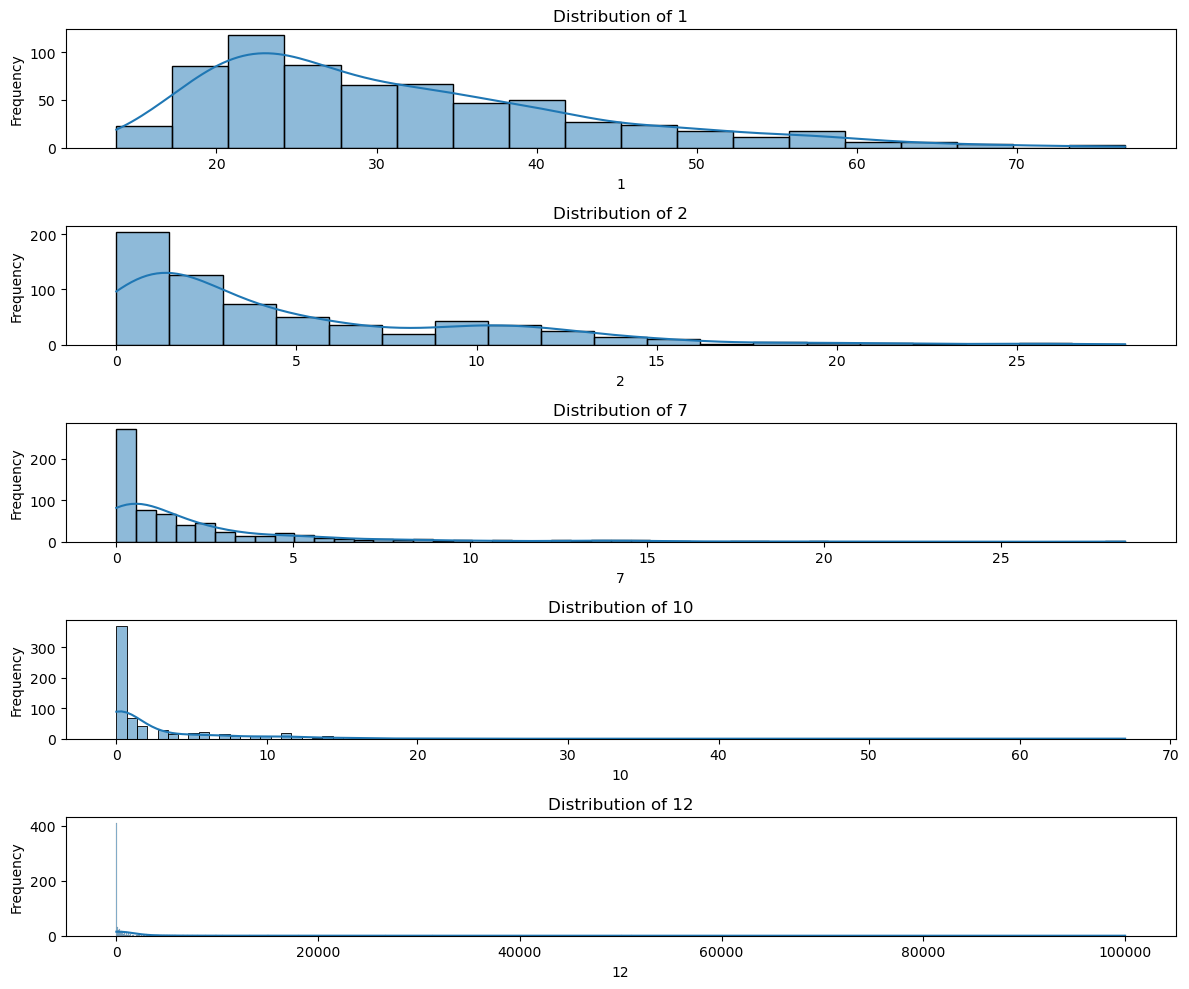

In [38]:
%matplotlib inline

# Check distribution for numerical features
numerical_cols = cc_apps.select_dtypes(include=['number']).columns

# Set up the plot size
plt.figure(figsize=(12, 10))

# Loop through each numerical column and plot its distribution
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)  # create subplots
    sns.histplot(cc_apps[col], kde=True)  # kde=True adds a kernel density estimate line
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

From this result, we know that all these columns have positive skewness, and some are severely skewed (especially Column 12). This means that most of the data is concentrated on the left side, while some extreme values (outliers) stretch far to the right. This is common for variables that follow an exponential-like growth pattern.

# Preprocessing

## Handling skewed features

Since we know the data is skewed, we need to handle it first to improve our model's performance. There are several methods to transform a skewed dataset, such as Log, Box-Cox, or Yeo-Johnson. However, I'll use the Log transformation here, as it's commonly used and works well for this type of data.

In [39]:
# Check the skewness before transformation
print("Before Transformation")
for col in numerical_cols:
    print(f"Column: {col} - Skewwness: {cc_apps[col].skew()}")

# Apply log transformation (ensure no zeros or negative values)
for col in numerical_cols:
    cc_apps[col] = cc_apps[col].apply(lambda x: np.log(x + 1))

# Check the skewness after transformation
print("\nAfter Transformation")
for col in numerical_cols:
    print(f"Column: {col} - Skewwness: {cc_apps[col].skew()}")

Before Transformation
Column: 1 - Skewwness: 1.0835761064547225
Column: 2 - Skewwness: 1.4696290161719654
Column: 7 - Skewwness: 2.895757380832724
Column: 10 - Skewwness: 5.055727376350335
Column: 12 - Skewwness: 12.87332117740245

After Transformation
Column: 1 - Skewwness: 0.3921656523279444
Column: 2 - Skewwness: 0.1683764676379458
Column: 7 - Skewwness: 0.8221095555848732
Column: 10 - Skewwness: 0.9984229266786302
Column: 12 - Skewwness: 0.5009126576404549


Let's plot it again.

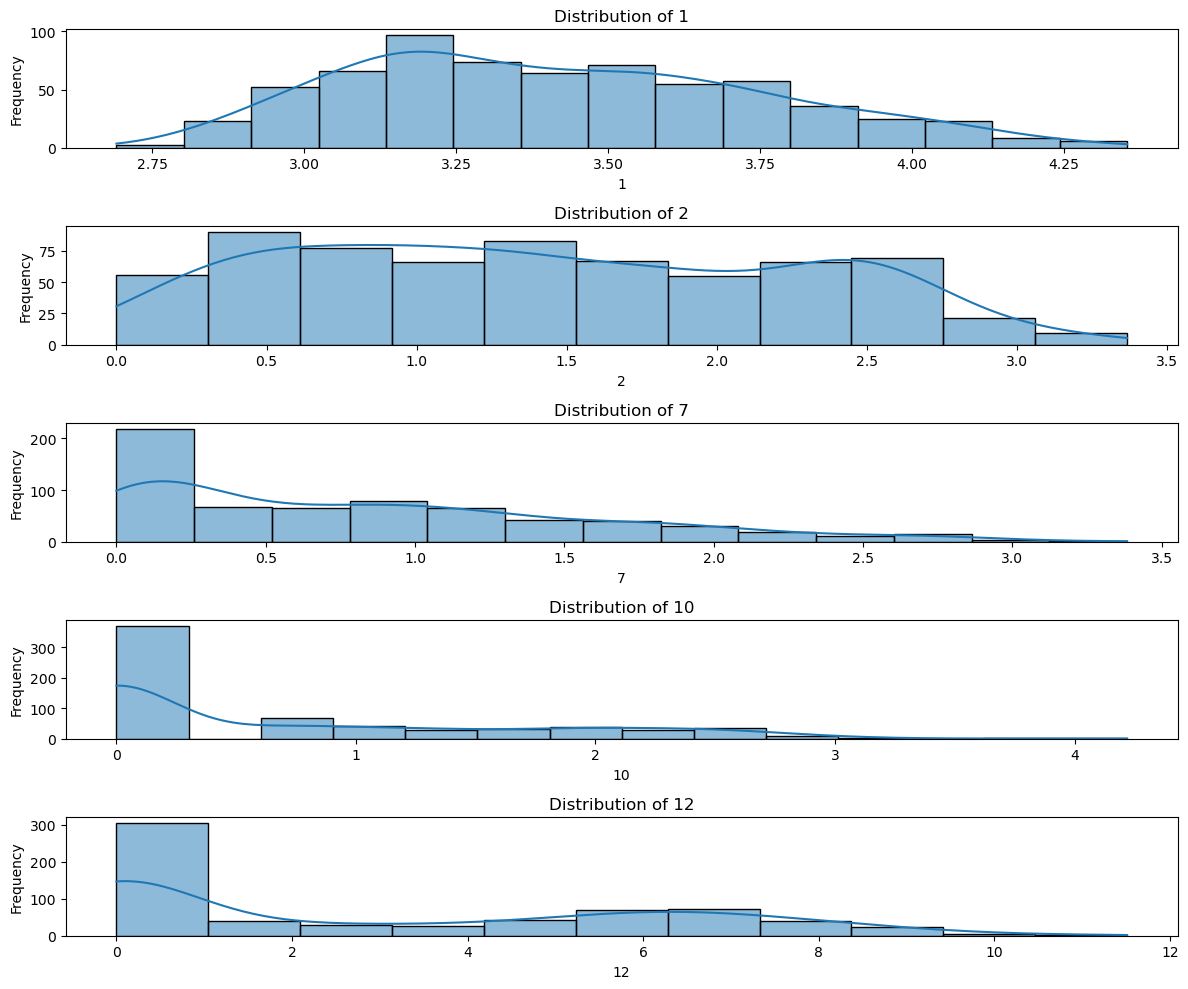

In [40]:
%matplotlib inline

# Check distribution for numerical features
numerical_cols = cc_apps.select_dtypes(include=['number']).columns

# Set up the plot size
plt.figure(figsize=(12, 10))

# Loop through each numerical column and plot its distribution
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)  # create subplots
    sns.histplot(cc_apps[col], kde=True)  # kde=True adds a kernel density estimate line
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

Here, we can see that the transformation has reduced the skewness significantly, bringing all columns much closer to a normal distribution. Most of the columns now have skewness values closer to 0, which indicates that their distributions are becoming more symmetric and closer to a normal distribution.

Because the transformations worked well, and the skewness is now low enough, so we can move forward to the next step.

## Encoding

Before building our model, the first step was to preprocess the categorical features in the dataset.

In [41]:
# Map all binary and non binary cols
binary_cols = [col for col in cc_apps.columns if cc_apps[col].dtype == 'object' and len(cc_apps[col].value_counts().values) == 2]
multi_cat_cols = [col for col in cc_apps.columns if cc_apps[col].dtype == 'object' and len(cc_apps[col].value_counts().values) > 2]

print(binary_cols)
print(multi_cat_cols)

[0, 8, 9, 13]
[3, 4, 5, 6, 11]


For features with binary values, we converted them into numerical representations of 0 and 1, allowing the model to interpret them more effectively. 

In [42]:
# Convert binary categories to 0/1
cc_apps.loc[:, 0] = cc_apps.loc[:, 0].apply(lambda x: 0 if x == 'a' else 1)
cc_apps.loc[:, 8] = cc_apps.loc[:, 8].apply(lambda x: 0 if x == 'f' else 1)
cc_apps.loc[:, 9] = cc_apps.loc[:, 9].apply(lambda x: 0 if x == 'f' else 1)
cc_apps.loc[:, 13] = cc_apps.loc[:, 13].apply(lambda x: 0 if x == '-' else 1)

# Type casting
for col in binary_cols:
    cc_apps[col] = cc_apps[col].astype('int')

In [43]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int32  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    object 
 4   4       659 non-null    object 
 5   5       659 non-null    object 
 6   6       659 non-null    object 
 7   7       659 non-null    float64
 8   8       659 non-null    int32  
 9   9       659 non-null    int32  
 10  10      659 non-null    float64
 11  11      659 non-null    object 
 12  12      659 non-null    float64
 13  13      659 non-null    int32  
dtypes: float64(5), int32(4), object(5)
memory usage: 61.9+ KB


Meanwhile, for categorical variables with more than two unique values, we applied **one-hot encoding**, which transformed these categories into separate binary columns. This ensured that the model did not mistakenly assume an ordinal relationship among them.

In [44]:
# One-Hot Encode remaining categorical columns
cc_apps = pd.get_dummies(cc_apps, columns=[col for col in multi_cat_cols if col not in binary_cols], drop_first=True)

In [45]:
cc_apps.head()

,0,1,2,7,8,9,10,12,13,3_u,...,6_dd,6_ff,6_h,6_j,6_n,6_o,6_v,6_z,11_p,11_s
0,1,3.46,0.00,0.81,1,1,0.69,0.00,1,True,...,False,False,False,False,False,False,True,False,False,False
1,0,4.09,1.70,1.40,1,1,1.95,6.33,1,True,...,False,False,True,False,False,False,False,False,False,False
2,0,3.24,0.41,0.92,1,0,0.00,6.72,1,True,...,False,False,True,False,False,False,False,False,False,False
3,1,3.36,0.93,1.56,1,1,1.79,1.39,1,True,...,False,False,False,False,False,False,True,False,False,False
4,1,3.05,1.89,1.00,1,0,0.00,0.00,1,True,...,False,False,False,False,False,False,True,False,False,True


In [46]:
# Convert column names to strings
cc_apps.columns = cc_apps.columns.astype(str)

cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int32  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   7       659 non-null    float64
 4   8       659 non-null    int32  
 5   9       659 non-null    int32  
 6   10      659 non-null    float64
 7   12      659 non-null    float64
 8   13      659 non-null    int32  
 9   3_u     659 non-null    bool   
 10  3_y     659 non-null    bool   
 11  4_gg    659 non-null    bool   
 12  4_p     659 non-null    bool   
 13  5_c     659 non-null    bool   
 14  5_cc    659 non-null    bool   
 15  5_d     659 non-null    bool   
 16  5_e     659 non-null    bool   
 17  5_ff    659 non-null    bool   
 18  5_i     659 non-null    bool   
 19  5_j     659 non-null    bool   
 20  5_k     659 non-null    bool   
 21  5_m     659 non-null    bool   
 22  5_

Now, we can see that after performing these transformations, the dataset expanded to **36 columns**, reflecting the newly encoded features. 

# Modeling

With the data now properly formatted, we moved on to splitting it into training and testing sets.

## Split Train & Test

In [47]:
# Prepare Feature Matrix X and Target y
X = cc_apps.drop(columns=['13'])
y = cc_apps['13']

display(X)
display(y)

,0,1,2,7,8,9,10,12,3_u,3_y,...,6_dd,6_ff,6_h,6_j,6_n,6_o,6_v,6_z,11_p,11_s
0,1,3.46,0.00,0.81,1,1,0.69,0.00,True,False,...,False,False,False,False,False,False,True,False,False,False
1,0,4.09,1.70,1.40,1,1,1.95,6.33,True,False,...,False,False,True,False,False,False,False,False,False,False
2,0,3.24,0.41,0.92,1,0,0.00,6.72,True,False,...,False,False,True,False,False,False,False,False,False,False
3,1,3.36,0.93,1.56,1,1,1.79,1.39,True,False,...,False,False,False,False,False,False,True,False,False,False
4,1,3.05,1.89,1.00,1,0,0.00,0.00,True,False,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,1,3.09,2.41,0.81,0,0,0.00,0.00,False,True,...,False,False,True,False,False,False,False,False,False,False
655,0,3.16,0.56,1.10,0,1,1.10,5.98,True,False,...,False,False,False,False,False,False,True,False,False,False
656,0,3.27,2.67,1.10,0,1,0.69,0.69,False,True,...,False,True,False,False,False,False,False,False,False,False
657,1,2.94,0.19,0.04,0,0,0.00,6.62,True,False,...,False,False,False,False,False,False,True,False,False,False


0      1
1      1
2      1
3      1
4      1
      ..
654    0
655    0
656    0
657    0
658    0
Name: 13, Length: 659, dtype: int32

To ensure a balanced approach, we allocated **80% of the data for training** and reserved **20% for testing**. This is a widely accepted practice in machine learning, as it provides sufficient data for model training while keeping a portion unseen for unbiased evaluation.  

In [48]:
# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=9
)

## Modelling with LazyClassifier

Next, instead of selecting a model manually, we leveraged [LazyClassifier](https://lazypredict.readthedocs.io/en/latest/usage.html#classification), an automated tool that quickly trains multiple machine learning models and ranks them based on performance.  

In [49]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=accuracy_score)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 31/31 [00:00<00:00, 39.74it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,accuracy_score,Time Taken
Model,,,,,,
LinearSVC,0.82,0.84,0.84,0.82,0.82,0.01
LinearDiscriminantAnalysis,0.82,0.84,0.84,0.82,0.82,0.01
RidgeClassifierCV,0.82,0.84,0.84,0.82,0.82,0.01
CalibratedClassifierCV,0.82,0.84,0.84,0.82,0.82,0.03
RidgeClassifier,0.82,0.84,0.84,0.82,0.82,0.01
PassiveAggressiveClassifier,0.82,0.84,0.84,0.82,0.82,0.01
Perceptron,0.80,0.83,0.83,0.81,0.80,0.01
LogisticRegression,0.81,0.82,0.82,0.81,0.81,0.01
LGBMClassifier,0.83,0.82,0.82,0.83,0.83,0.04


After evaluating several models, the **LGBMClassifier (LightGBM)** stood out as the best-performing one, achieving an **accuracy of 83%**. Given its strong performance, we chose this model for further tuning and evaluation.

## Modelling w (Best Model)

Although the train-test split provided an initial accuracy score, relying solely on it poses risks such as **data leakage** and **biased evaluation** due to random sampling. To get a more reliable estimate of the model's performance, we applied **cross-validation**, a technique that repeatedly trains and tests the model on different subsets of the data.

In [50]:
# Create the LGBMClassifier model
best_model = lgb.LGBMClassifier(verbose=-1)

# Perform cross-validation (using 5-fold cross-validation)
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# Calculate the mean accuracy score from cross-validation
best_svc_score = cv_scores.mean()

# Print the cross-validation results
print(f"Best LinearSVC Model Accuracy (from cross-validation): {best_svc_score:.4f}")

Best LinearSVC Model Accuracy (from cross-validation): 0.8347


Here, the model maintained an accuracy of **83%**, reinforcing our confidence in its consistency and reliability. 

# Evaluation

To gain deeper insight into the model’s performance, let't try to visualize its predictions using a **confusion matrix**.

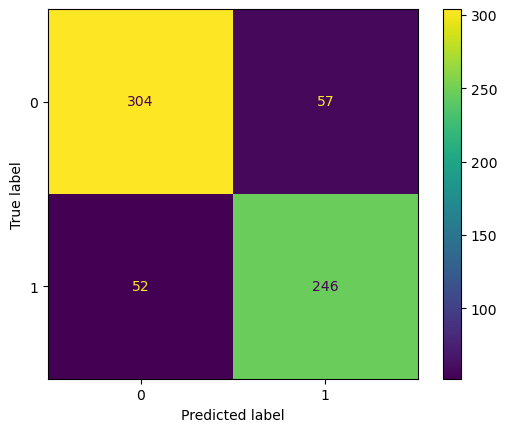

In [51]:
# Use cross_val_predict to get predictions from cross-validation
y_pred_cv = cross_val_predict(best_model, X, y, cv=5)

# Generate the confusion matrix
cm = confusion_matrix(y, y_pred_cv)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot()
plt.show()

From the matrix, we observed that the model **misclassified 57 instances where the False label was predicted as True (False Positives)** and **52 instances where the True label was predicted as False (False Negatives)**. These misclassifications indicated areas for improvement, particularly in handling class imbalances within the dataset.  

#  Hyperparameter Tuning

Recognizing that further optimization was needed, we proceeded with **hyperparameter tuning** using **GridSearchCV**. This technique systematically tests different parameter combinations to find the best configuration for the model.

In [52]:
# Hyperparameter tuning for LGBMClassifier
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [20, 50, 100],
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(verbose=-1), param_grid=param_grid, cv=5, scoring='accuracy')

# Fit grid search
grid_search.fit(X, y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy (from GridSearchCV): {best_score:.4f}")

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31}
Best Accuracy (from GridSearchCV): 0.8514


After fine-tuning, the model’s accuracy improved from **83% to 85%**, demonstrating the impact of parameter optimization. The best combination of hyperparameters included a **learning rate of 0.1, 50 estimators, and 31 leaves**, which enhanced the model’s ability to make accurate predictions.  